## Test merging 2D and 3D predictions for post-processing

In [1]:
import os
import copy
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
# %matplotlib notebook

from scipy import ndimage

In [2]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

In [3]:
# define the test data
FOLDER = "/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/test_postprocessing/test_imgs"
orig_img_file = os.path.join(FOLDER, "a26_06_Image.nii.gz")
orig_seg_file = os.path.join(FOLDER, "a26_06_Label.nii.gz")
pred_2D_file = os.path.join(FOLDER, "a26_06_Image_2DUnet_output.nii.gz")
pred_3D_file = os.path.join(FOLDER, "a26_06_Image_3DUnet_output.nii.gz")

In [4]:
# read data and select a 2D slice to test
orig_img_sitk = load_nifty_volume_as_4d_array(orig_img_file)
orig_img = orig_img_sitk["data_array"]

orig_seg_sitk = load_nifty_volume_as_4d_array(orig_seg_file)
orig_seg = np.squeeze(orig_seg_sitk["data_array"])

pred_2D_sitk = load_nifty_volume_as_4d_array(pred_2D_file)
pred_2D = np.squeeze(pred_2D_sitk["data_array"])

pred_3D_sitk = load_nifty_volume_as_4d_array(pred_3D_file)
pred_3D = np.squeeze(pred_3D_sitk["data_array"])

In [5]:
def make_comparison_figure(img, seg, pred2D, postprocessed, 
                           slice_y=90, aspect=4.0, title_last="postprocessed", suptitle="Data"):
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,8), sharey='row', gridspec_kw={'wspace': 0})
    fig.suptitle(suptitle, y=0.7)
    ax[0].imshow(np.squeeze(img[:, slice_y, :]), aspect=aspect, cmap="gray")
    ax[0].set_title("original img")
    ax[1].imshow(np.squeeze(seg[:, slice_y, :]), interpolation="nearest", aspect=aspect)
    ax[1].set_title("original seg")
    ax[2].imshow(np.squeeze(pred2D[:, slice_y, :]),aspect=aspect)
    ax[2].set_title("2D prediction")
    ax[3].imshow(np.squeeze(postprocessed[:, slice_y, :]), aspect=aspect)
    ax[3].set_title(title_last)   
    
    return 

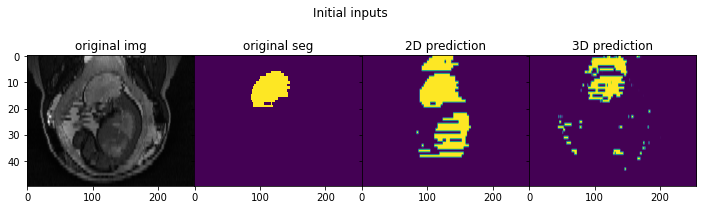

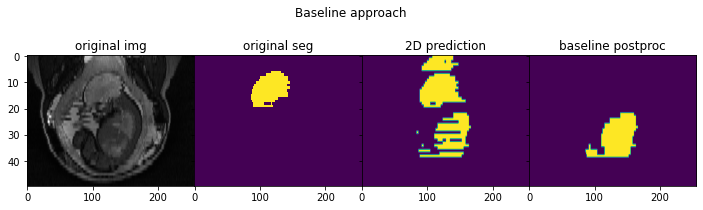

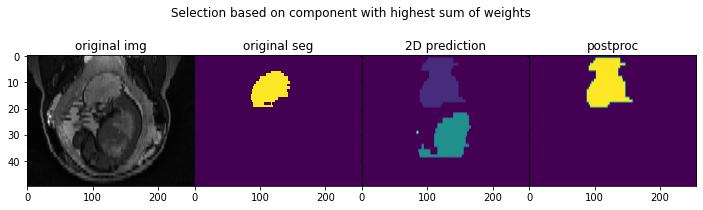

In [13]:
# input data
make_comparison_figure(orig_img, orig_seg, pred_2D, pred_3D, title_last="3D prediction", suptitle="Initial inputs")

# baseline approach: ignore the pred_3D just keep the largest connected component from 2D 
strt = ndimage.generate_binary_structure(3,2) # iterate structure
img = ndimage.morphology.binary_closing(pred_2D, strt)

s = ndimage.generate_binary_structure(3,1) # iterate structure
labeled_array, numpatches = ndimage.label(img,s) # labeling
sizes = ndimage.sum(img,labeled_array,range(1,numpatches+1))
max_label = np.where(sizes == sizes.max())[0] + 1
output = np.asarray(labeled_array == max_label, np.uint8)

make_comparison_figure(orig_img, orig_seg, pred_2D, output, 
                       title_last="baseline postproc", suptitle="Baseline approach")

# first approach: get the label with the heighest weights
img = ndimage.morphology.binary_closing(pred_2D, strt)
weight_map = pred_3D

s = ndimage.generate_binary_structure(3,1) # iterate structure
labeled_array, numpatches = ndimage.label(img,s) # labeling
sizes = ndimage.sum(img,labeled_array,range(1,numpatches+1))
weights = ndimage.sum(weight_map,labeled_array,range(1,numpatches+1))
max_label = np.where(weights == weights.max())[0] + 1
output_2 = np.asarray(labeled_array == max_label, np.uint8)

make_comparison_figure(orig_img, orig_seg, img, output_2, 
                       title_last="postproc", suptitle="Selection based on component with highest sum of weights")

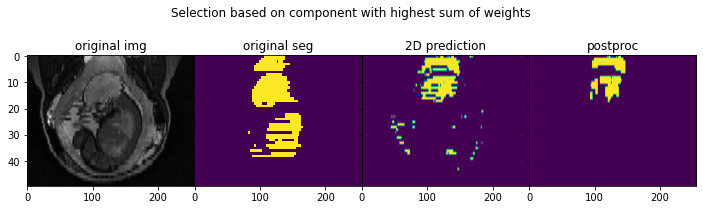

In [12]:
# first approach: get the label with the heighest weights
thr_map = 0.8
img = ndimage.morphology.binary_closing(pred_2D, strt)
weight_map = copy.deepcopy(pred_3D)

s = ndimage.generate_binary_structure(3,1) # iterate structure
binary_map = weight_map > thr_map
binary_map = ndimage.morphology.binary_opening(binary_map, strt)
labeled_map, numpatches_map = ndimage.label(binary_map, s)
weights = ndimage.sum(weight_map,labeled_map,range(1,numpatches_map+1))
max_label_map = np.where(weights == weights.max())[0] + 1
weight_map[labeled_map != max_label_map] = 0

make_comparison_figure(orig_img, pred_2D, pred_3D, binary_map, 
                       title_last="postproc", suptitle="Selection based on component with highest sum of weights")

# #     # tentativo
# #     binary_map = weight_map > thr_map
# #     labeled_map, numpatches_map = ndimage.label(binary_map,s)
# #     weights = ndimage.sum(weight_map,labeled_map,range(1,numpatches_map+1))
# #     max_label_map = np.where(weights == weights.max())[0] + 1
# #     # set to zero weights outside the max_label_map
# #     weight_map[labeled_map != max_label_map] = 0
# #     final_weights = ndimage.sum(weight_map,labeled_array,range(1,numpatches+1))
# #     max_label =  np.where(final_weights == final_weights.max())[0] + 1
# #     print(max_label)
#     return np.asarray(labeled_array == max_label, np.uint8), labeled_array